In [1]:
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import  RandomForestRegressor

from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline

# Описание данных.

**order_id**: Идентификатор заказа, уникальный для каждого заказа. Эта функция не может напрямую влиять на время доставки, но может быть полезна для идентификации конкретных заказов. 

**payment_method**: Способ оплаты, выбранный клиентами, может косвенно влиять на время доставки. Например, если способ оплаты включает дополнительные этапы проверки или задержки, это может повлиять на общее время доставки.

**order_dt**: Дата и время заказа могут иметь решающее значение для прогнозирования времени доставки. Извлекая из этой функции релевантную информацию, такую ​​как день недели, месяц или время суток, мы можем зафиксировать временные закономерности, которые могут повлиять на время доставки.

**delivery_time**: Эта функция представляет целевую переменную, которую мы хотим предсказать. Он обеспечивает фактическое время, необходимое для доставки, и будет служить зависимой переменной в нашей модели прогнозирования.

**product_id**: Сам по себе идентификатор продукта не может напрямую влиять на время доставки. Однако, если определенные продукты имеют особые требования к доставке, например скоропортящиеся товары или крупная бытовая техника, эта функция может косвенно повлиять на время доставки.

**product_name**: Название продукта дублирует product_id и нужно для понимания данных.

**amount**: Размер заказа может косвенно повлиять на время доставки. Например, для более крупных заказов может потребоваться дополнительное время обработки или другие способы доставки. 

**product_group_name**: Представляет группу продуктов. Подобно идентификатору продукта, она может не иметь прямого влияния на время доставки. Однако, если определенные группы продуктов имеют особые требования к доставке или обработке, эти характеристики могут быть информативными для прогнозирования времени доставки.

**price**: Цена товара может косвенно влиять на время доставки. Более дорогие товары могут потребовать более бережного обращения или специализированных служб доставки, что может повлиять на общее время доставки. 

**address**: Адрес доставки может играть важную роль в прогнозировании времени доставки. Такие факторы, как расстояние, местоположение и ограничения доставки, связанные с конкретными областями, могут повлиять на время, необходимое для доставки.

In [2]:
# Загружаем данные
df = pd.read_csv('sql.csv')
df.head()

,order_id,payment_method,order_dt,delivery_time,product_id,amount,product_group_name,product_name,price,address
0,98929,offline,2023-04-06,47,NaN,NaN,NaN,NaN,NaN,Махачкала
1,51229,online,2023-03-25,39,11.0,46.0,Продукты,Огурец,5.0,Зеленогорск
2,51229,online,2023-03-25,39,13.0,40.0,Напитки,Злой кола,500.0,Зеленогорск
3,12295,online,2022-03-14,33,7.0,30.0,Часы,Часы настенные,3000.0,Новоалтайск
4,12295,online,2022-03-14,33,8.0,19.0,Часы,Часы напольные,500.0,Новоалтайск


In [3]:
# Преобразуем payment_method в числовой формат
df['payment_method'] = df['payment_method'].map({'offline': 0, 'online': 1})

In [4]:
# Смотрим процент пропусков
df.isnull().sum() / df.shape[0] * 100

order_id              0.000000
payment_method        0.000000
order_dt              0.000000
delivery_time         0.000000
product_id            4.915794
amount                4.915794
product_group_name    4.915794
product_name          4.915794
price                 4.915794
address               0.075861
dtype: float64

In [5]:
# Выводим данные с пропусками
df[df.isnull().any(axis=1)].head(10)

,order_id,payment_method,order_dt,delivery_time,product_id,amount,product_group_name,product_name,price,address
0,98929,0,2023-04-06,47,NaN,NaN,NaN,NaN,NaN,Махачкала
6,22832,1,2022-02-02,60,NaN,NaN,NaN,NaN,NaN,Челябинск
69,47979,0,2020-03-19,44,NaN,NaN,NaN,NaN,NaN,Белгород
70,55500,0,2021-03-01,56,NaN,NaN,NaN,NaN,NaN,Саратов
71,7073,0,2021-12-26,48,NaN,NaN,NaN,NaN,NaN,Энгельс
94,77466,0,2020-12-15,9,NaN,NaN,NaN,NaN,NaN,Чайковский
100,48714,1,2021-01-21,21,NaN,NaN,NaN,NaN,NaN,Керчь
132,27606,0,2023-01-15,58,NaN,NaN,NaN,NaN,NaN,Горно-Алтайск
151,96772,0,2023-02-27,2,NaN,NaN,NaN,NaN,NaN,Раменское
172,54988,0,2023-01-20,52,NaN,NaN,NaN,NaN,NaN,Иркутск


In [6]:
# Удаляем пропуски
df = df.dropna()
df.shape

(6262, 10)

In [7]:
# Смотрим типы данных
df.dtypes

order_id                int64
payment_method          int64
order_dt               object
delivery_time           int64
product_id            float64
amount                float64
product_group_name     object
product_name           object
price                 float64
address                object
dtype: object

In [8]:
# Преобразуем типы данных
df['order_dt'] = pd.to_datetime(df['order_dt'])
df['product_id'] = df['product_id'].astype('int64')
df['price'] = df['price'].astype('int64')
df['amount'] = df['amount'].astype('int64')

In [9]:
# Проверяем на дубликаты
df.duplicated().sum()

69

In [10]:
# Удаляем дубликаты
df = df.drop_duplicates()
df.shape

(6193, 10)

In [11]:
# Проверяем данные на выбросы
df.describe()

,order_id,payment_method,delivery_time,product_id,amount,price
count,6193.000000,6193.000000,6193.000000,6193.000000,6193.000000,6193.000000
mean,50055.266914,0.479735,30.491361,8.111255,25.552721,8546.505732
std,28482.968382,0.499630,17.361373,4.306348,14.651436,22760.458665
min,87.000000,0.000000,1.000000,1.000000,1.000000,5.000000
25%,25811.000000,0.000000,15.000000,4.000000,13.000000,50.000000
50%,50365.000000,0.000000,31.000000,8.000000,26.000000,500.000000
75%,73440.000000,1.000000,45.000000,12.000000,38.000000,3000.000000
max,99983.000000,1.000000,60.000000,15.000000,50.000000,90000.000000


<Axes: >

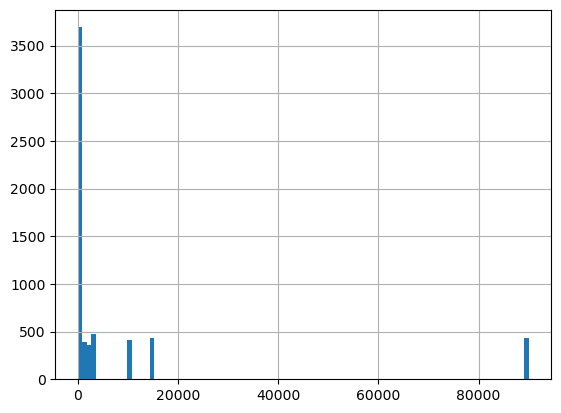

In [12]:
# Смотрим на распределение price
df['price'].hist(bins=100)

In [13]:
# Посмотрим на квантили
df['price'].quantile([0.25, 0.75])

0.25      50.0
0.75    3000.0
Name: price, dtype: float64

In [14]:
# Добавляем новые признаки
df['price_category'] = df['price'].apply(lambda x: 0 if x <= 50 else 1 if x > 50 and x <= 3000 else 2)
df['month'] = df['order_dt'].dt.month
df['year'] = df['order_dt'].dt.year
df['day'] = df['order_dt'].dt.day
df['weekday'] = df['order_dt'].dt.weekday
df['week'] = df['order_dt'].dt.isocalendar().week
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)

In [15]:
# Удаляем ненужные столбцы
df = df.drop(['order_dt', 'product_name', 'order_id', 'price'], axis=1)
df.head()

,payment_method,delivery_time,product_id,amount,product_group_name,address,price_category,month,year,day,weekday,week,is_weekend
1,1,39,11,46,Продукты,Зеленогорск,0,3,2023,25,5,12,1
2,1,39,13,40,Напитки,Зеленогорск,1,3,2023,25,5,12,1
3,1,33,7,30,Часы,Новоалтайск,1,3,2022,14,0,11,0
4,1,33,8,19,Часы,Новоалтайск,1,3,2022,14,0,11,0
5,0,59,13,13,Напитки,Бузулук,1,4,2023,5,2,14,0


In [16]:
# Смотрим на корреляцию delivery_time с другими признаками
df.corr(numeric_only=True)['delivery_time'].sort_values(ascending=False)

delivery_time     1.000000
is_weekend        0.038121
payment_method    0.023723
weekday           0.023392
week              0.021187
month             0.020344
price_category    0.018675
year              0.014481
amount            0.006961
day               0.003929
product_id       -0.022088
Name: delivery_time, dtype: float64

In [17]:
# Преобразуем категориальные признаки
df = pd.get_dummies(df, columns=['product_group_name', 'address'])
df.head()

,payment_method,delivery_time,product_id,amount,price_category,month,year,day,weekday,week,...,address_Щекино,address_Щелково,address_Электросталь,address_Элиста,address_Энгельс,address_Южно-Сахалинск,address_Юрга,address_Якутск,address_Ялта,address_Ярославль
1,1,39,11,46,0,3,2023,25,5,12,...,0,0,0,0,0,0,0,0,0,0
2,1,39,13,40,1,3,2023,25,5,12,...,0,0,0,0,0,0,0,0,0,0
3,1,33,7,30,1,3,2022,14,0,11,...,0,0,0,0,0,0,0,0,0,0
4,1,33,8,19,1,3,2022,14,0,11,...,0,0,0,0,0,0,0,0,0,0
5,0,59,13,13,1,4,2023,5,2,14,...,0,0,0,0,0,0,0,0,0,0


Целевая переменная: **delivery_time** - время доставки в днях. Значит это задача регрессии.

In [46]:
# Разделяем данные на обучающую и тестовую выборки
X = df.drop('delivery_time', axis=1)
y = df['delivery_time']

Для оценки качества моделей будем использовать метрику **RMSE**. Потому что она позволяет оценить насколько сильно ошибается модель в среднем. И в нашем случае это важно, потому что мы хотим минимизировать среднюю ошибку.

In [49]:
# Создаем модели
pl = Pipeline([('scaler', StandardScaler()), ('regressor', LinearRegression())])
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)

# Сравниваем с использованием кросс-валидации
models = [pl, dt, rf]

for model in models:
    print(model)
    print(cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error').mean())


Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])
-11146385558908.309
DecisionTreeRegressor(random_state=42)
-23.291131298538374
RandomForestRegressor(random_state=42)
-20.43770470703847


#### Вывод:
В смысле выбранной метрики на кросс-валидации лучшим оказался алгоритм **Случайного леса**.